# Building Mamba-UNet from Scratch

**Architecture**:
- Input: (B, 3, 512, 512) RGB images
- PatchEmbed: Image → patches
- Encoder: Process with Mamba
- Decoder: Patches → mask
- Output: (B, 1, 512, 512) segmentation mask

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba
import matplotlib.pyplot as plt
import numpy as np

# Check environment
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

PyTorch: 2.4.1+cu121
CUDA available: True
Device: NVIDIA GeForce RTX 4060


---
## Step 1: PatchEmbedding

### Convert image to patch tokens

**What it does**:
- Takes 512×512 image
- Breaks into 16×16 patches
- Result: 32×32 grid = 1024 patches
- Each patch becomes a token

**Method**: Use Conv2d with stride=patch_size

In [2]:
class PatchEmbedding(nn.Module):
    """
    Convert image to patch tokens.
    
    Uses Conv2d for efficient patch extraction (standard approach from ViT).
    """
    def __init__(self, patch_size=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x: (B, 3, 512, 512)
        x = self.proj(x)  # (B, embed_dim, 32, 32)
        x = x.flatten(2)   # (B, embed_dim, 1024)
        x = x.transpose(1, 2)  # (B, 1024, embed_dim)
        return x

# Test PatchEmbedding
print("=== Testing PatchEmbedding ===")
patch_embed = PatchEmbedding(patch_size=16, embed_dim=128)
dummy_img = torch.randn(2, 3, 512, 512)  # Batch of 2 images

patches = patch_embed(dummy_img)
print(f"Input shape: {dummy_img.shape}")
print(f"Output shape: {patches.shape}")
print(f"Expected: (2, 1024, 128) ✓" if patches.shape == (2, 1024, 128) else "Expected: (2, 1024, 128) ✗")

# Check parameters
n_params = sum(p.numel() for p in patch_embed.parameters())
print(f"\nParameters: {n_params:,}")

=== Testing PatchEmbedding ===
Input shape: torch.Size([2, 3, 512, 512])
Output shape: torch.Size([2, 1024, 128])
Expected: (2, 1024, 128) ✓

Parameters: 98,432


---
## Step 2: Simple Mamba Encoder

### Stack a few Mamba layers to process the tokens

In [3]:
class MambaEncoder(nn.Module):
    """
    Simple Mamba encoder.
    
    Stacks multiple Mamba layers to process patch tokens.
    Uses pre-norm architecture: LayerNorm → Mamba → Residual connection.
    """
    def __init__(self, dim=128, num_layers=3):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        # Create Mamba layers
        for _ in range(num_layers):
            self.layers.append(nn.ModuleDict({
                'norm': nn.LayerNorm(dim),
                'mamba': Mamba(d_model=dim, d_state=16, d_conv=4, expand=2),
            }))
    
    def forward(self, x):
        # x: (B, num_patches, dim)
        for layer_dict in self.layers:
            # Pre-norm residual architecture
            x_norm = layer_dict['norm'](x)
            x = x + layer_dict['mamba'](x_norm)
        return x

# Test MambaEncoder
print("=== Testing MambaEncoder ===")
encoder = MambaEncoder(dim=128, num_layers=3)
patches = torch.randn(2, 1024, 128)

# Moving all the tensors to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = encoder.to(device)
patches = patches.to(device)

output = encoder(patches)
print(f"Input shape: {patches.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected: (2, 1024, 128) ✓" if output.shape == (2, 1024, 128) else "Expected: (2, 1024, 128) ✗")

# Check parameters
n_params = sum(p.numel() for p in encoder.parameters())
print(f"\nParameters: {n_params:,}")

=== Testing MambaEncoder ===
Input shape: torch.Size([2, 1024, 128])
Output shape: torch.Size([2, 1024, 128])
Expected: (2, 1024, 128) ✓

Parameters: 350,208


---
## Step 3: Decoder

**Goal**: Convert patches back to full-resolution mask

In [4]:
class Decoder(nn.Module):
    """
    Simple CNN decoder to upsample patches back to image resolution.
    
    Converts: (B, num_patches, dim) → (B, 1, H, W)
    """
    def __init__(self, dim=128, num_classes=1):
        super().__init__()
        
        # First, reshape patches to spatial format
        # Input will be (B, 1024, 128)
        # We need to convert to (B, 128, 32, 32) for upsampling
        
        # Upsampling layers: 32×32 → 64×64 → 128×128 → 256×256 → 512×512
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )  # 32×32 → 64×64
        
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )  # 64×64 → 128×128
        
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )  # 128×128 → 256×256
        
        self.upsample4 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )  # 256×256 → 512×512
        
        # Final layer: predict segmentation mask
        self.out = nn.Conv2d(8, num_classes, kernel_size=1)
    
    def forward(self, x):
        # x: (B, 1024, 128) patch tokens
        B = x.shape[0]
        
        # Reshape patches back to spatial format
        # (B, 1024, 128) → (B, 128, 32, 32)
        x = x.transpose(1, 2)  # (B, 128, 1024)
        x = x.reshape(B, 128, 32, 32)  # (B, 128, 32, 32)
        
        # Upsample
        x = self.upsample1(x)  # (B, 64, 64, 64)
        x = self.upsample2(x)  # (B, 32, 128, 128)
        x = self.upsample3(x)  # (B, 16, 256, 256)
        x = self.upsample4(x)  # (B, 8, 512, 512)
        
        # Output
        x = self.out(x)  # (B, 1, 512, 512)
        return x

# Test Decoder
print("=== Testing Decoder ===")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

decoder = Decoder(dim=128, num_classes=1).to(device)
patches = torch.randn(2, 1024, 128).to(device)

mask = decoder(patches)
print(f"Input shape: {patches.shape}")
print(f"Output shape: {mask.shape}")
print(f"Expected: (2, 1, 512, 512) ✓" if mask.shape == (2, 1, 512, 512) else "Expected: (2, 1, 512, 512) ✗")

# Check parameters
n_params = sum(p.numel() for p in decoder.parameters())
print(f"\nParameters: {n_params:,}")

=== Testing Decoder ===
Input shape: torch.Size([2, 1024, 128])
Output shape: torch.Size([2, 1, 512, 512])
Expected: (2, 1, 512, 512) ✓

Parameters: 174,209


---
## Step 4: Full MambaUNet

**Goal**: Combine all pieces

In [5]:
class MambaUNet(nn.Module):
    """
    Simple Mamba-UNet for segmentation.
    
    Architecture:
    1. PatchEmbedding: Image → patch tokens
    2. MambaEncoder: Process tokens with Mamba layers
    3. Decoder: Upsample back to image resolution
    
    Input:  (B, 3, 512, 512) RGB images
    Output: (B, 1, 512, 512) segmentation masks
    """
    def __init__(self, patch_size=16, embed_dim=128, num_mamba_layers=3, num_classes=1):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)
        self.encoder = MambaEncoder(dim=embed_dim, num_layers=num_mamba_layers)
        self.decoder = Decoder(dim=embed_dim, num_classes=num_classes)
    
    def forward(self, x):
        # x: (B, 3, 512, 512)
        
        # Step 1: Image → patches
        x = self.patch_embed(x)  # (B, 1024, 128)
        
        # Step 2: Process with Mamba
        x = self.encoder(x)  # (B, 1024, 128)
        
        # Step 3: Upsample to mask
        x = self.decoder(x)  # (B, 1, 512, 512)
        
        return x

# Test full MambaUNet
print("=== Testing Full MambaUNet ===")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

model = MambaUNet(
    patch_size=16,
    embed_dim=128,
    num_mamba_layers=3,
    num_classes=1
).to(device)

# Test with dummy image
dummy_image = torch.randn(2, 3, 512, 512).to(device)
print(f"Input image: {dummy_image.shape}")

output_mask = model(dummy_image)
print(f"Output mask: {output_mask.shape}")
print(f"Expected: (2, 1, 512, 512) ✓" if output_mask.shape == (2, 1, 512, 512) else "Expected: (2, 1, 512, 512) ✗")

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Show breakdown by component
patch_embed_params = sum(p.numel() for p in model.patch_embed.parameters())
encoder_params = sum(p.numel() for p in model.encoder.parameters())
decoder_params = sum(p.numel() for p in model.decoder.parameters())

print(f"\nParameter breakdown:")
print(f"  PatchEmbedding: {patch_embed_params:,}")
print(f"  Encoder (Mamba): {encoder_params:,}")
print(f"  Decoder: {decoder_params:,}")

=== Testing Full MambaUNet ===
Using device: cuda

Input image: torch.Size([2, 3, 512, 512])
Output mask: torch.Size([2, 1, 512, 512])
Expected: (2, 1, 512, 512) ✓

Total parameters: 622,849

Parameter breakdown:
  PatchEmbedding: 98,432
  Encoder (Mamba): 350,208
  Decoder: 174,209


In [6]:
# Trace shapes through the network
print("\n=== Data Flow Through Model ===")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MambaUNet(patch_size=16, embed_dim=128, num_mamba_layers=3).to(device)
x = torch.randn(2, 3, 512, 512).to(device)

print(f"Input:              {x.shape}")

x = model.patch_embed(x)
print(f"After PatchEmbed:   {x.shape}")

x = model.encoder(x)
print(f"After Encoder:      {x.shape}")

x = model.decoder(x)
print(f"After Decoder:      {x.shape}")

print("\n✓ Complete end-to-end pipeline works!")


=== Data Flow Through Model ===
Input:              torch.Size([2, 3, 512, 512])
After PatchEmbed:   torch.Size([2, 1024, 128])
After Encoder:      torch.Size([2, 1024, 128])
After Decoder:      torch.Size([2, 1, 512, 512])

✓ Complete end-to-end pipeline works!


---
## Test with Real Images

Once the model works, test with simple test images

=== Creating Simple Test Images ===

Images shape: torch.Size([2, 3, 512, 512])
Ground truth shape: torch.Size([2, 1, 512, 512])



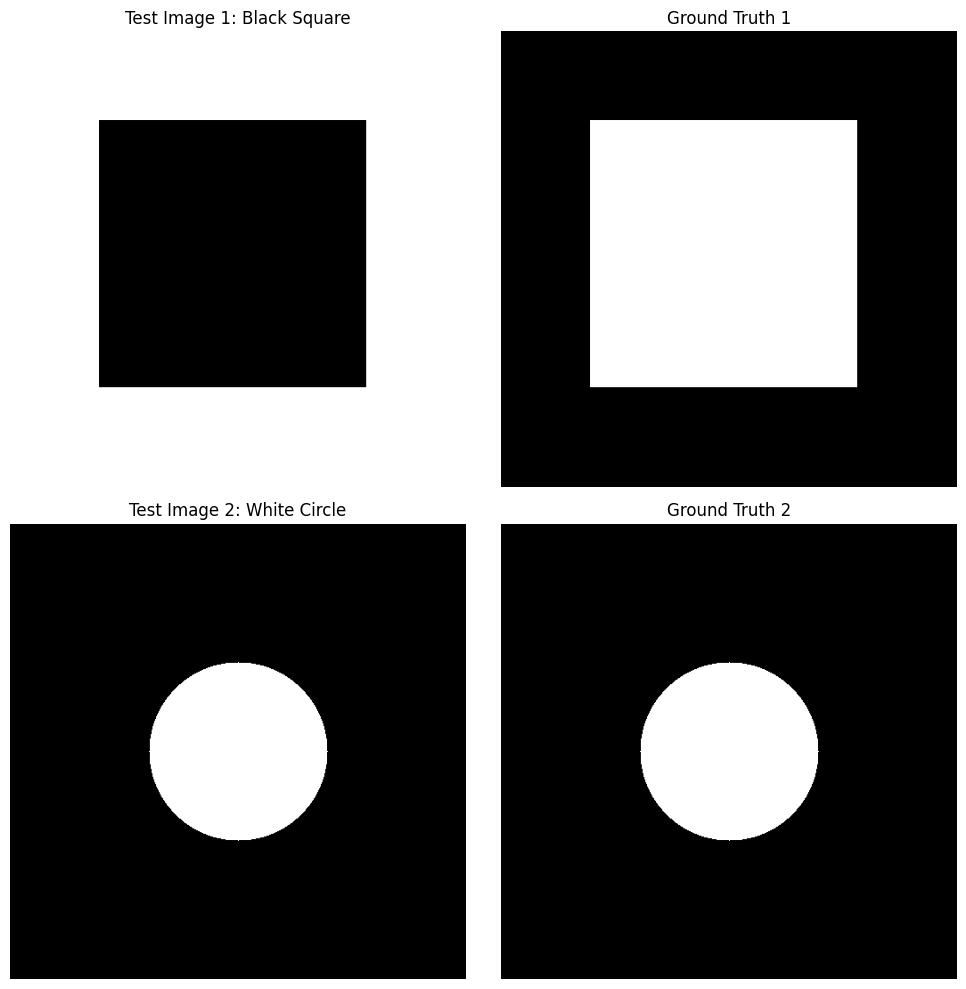

Test images created!



In [7]:
print("=== Creating Simple Test Images ===\n")

def create_test_images():
    """
    Create simple test images for visual verification.
    Returns: images, ground_truth masks
    """
    B = 2  # batch size
    H, W = 512, 512
    
    images = torch.zeros(B, 3, H, W)
    masks = torch.zeros(B, 1, H, W)
    
    # Image 1: Black square on white background
    images[0] = 1.0  # White background
    images[0, :, 100:400, 100:400] = 0.0  # Black square
    masks[0, 0, 100:400, 100:400] = 1.0  # Ground truth: square
    
    # Image 2: White circle on black background
    images[1] = 0.0  # Black background
    
    # Create circle using numpy
    y, x = np.ogrid[:H, :W]
    center_y, center_x = H // 2, W // 2
    radius = 100
    circle_mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
    
    images[1, :, circle_mask] = 1.0  # White circle
    masks[1, 0, circle_mask] = 1.0   # Ground truth: circle
    
    return images, masks

# Create test images
images, gt_masks = create_test_images()
print(f"Images shape: {images.shape}")
print(f"Ground truth shape: {gt_masks.shape}\n")

# Visualize test images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Image 1
axes[0, 0].imshow(images[0].permute(1, 2, 0))
axes[0, 0].set_title("Test Image 1: Black Square")
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_masks[0, 0], cmap='gray')
axes[0, 1].set_title("Ground Truth 1")
axes[0, 1].axis('off')

# Image 2
axes[1, 0].imshow(images[1].permute(1, 2, 0))
axes[1, 0].set_title("Test Image 2: White Circle")
axes[1, 0].axis('off')

axes[1, 1].imshow(gt_masks[1, 0], cmap='gray')
axes[1, 1].set_title("Ground Truth 2")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Test images created!\n")

=== Running Model on Test Images ===

Predictions shape: torch.Size([2, 1, 512, 512])
Predictions range: [0.2643, 0.2845]



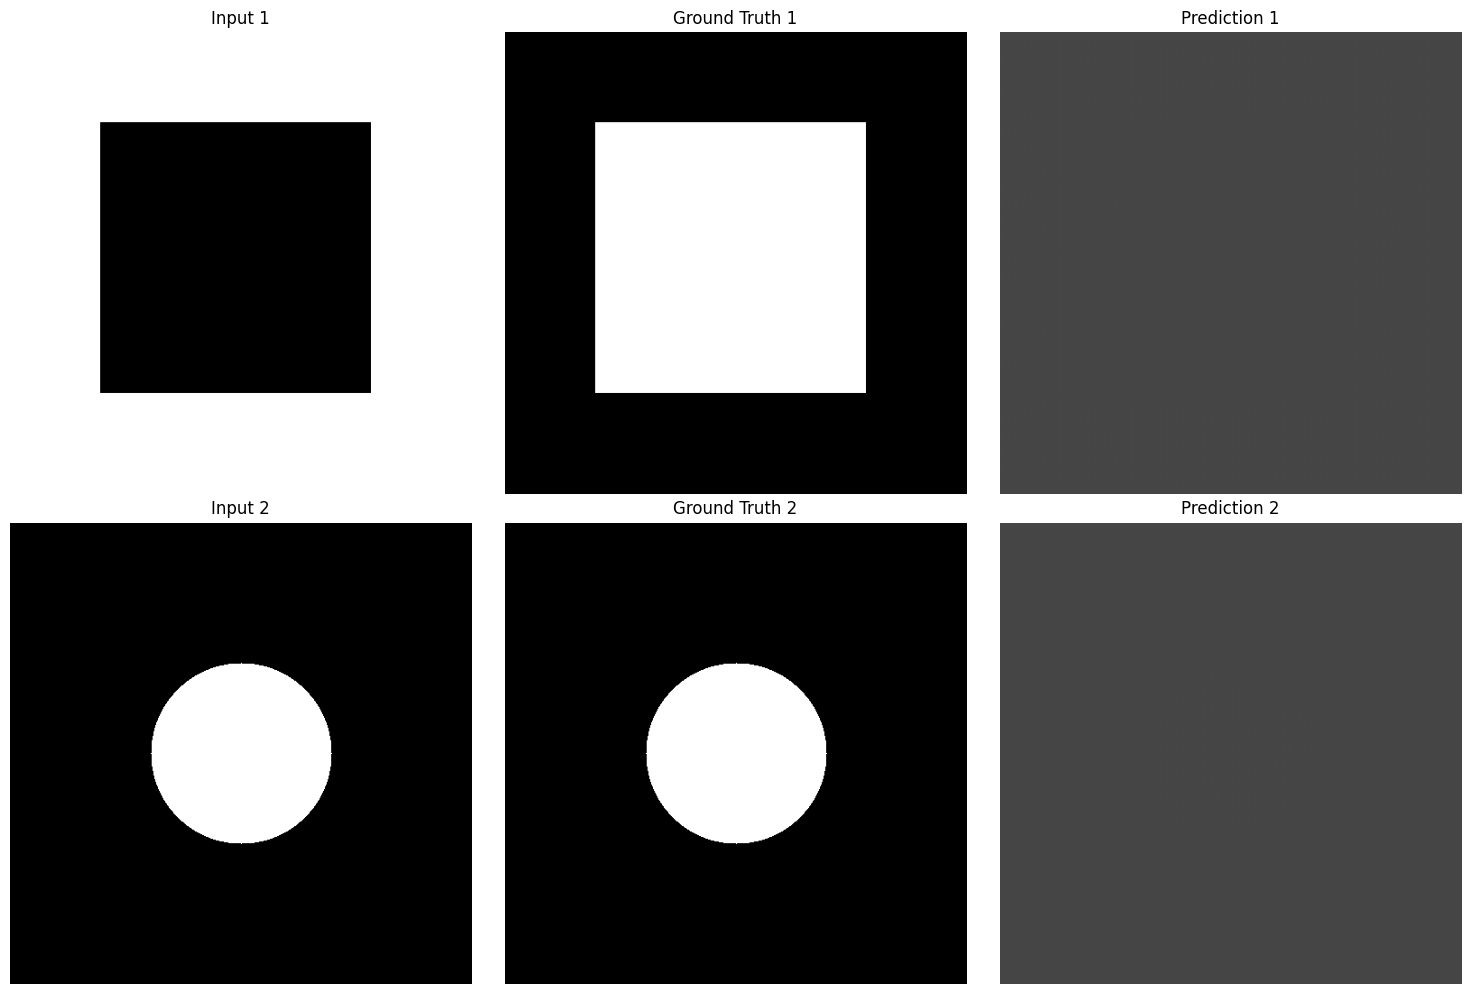

✓ Model successfully processes images!
  Note: Predictions are random (untrained model)
  After training, predictions should match ground truth


In [8]:
# Run model on test images
print("=== Running Model on Test Images ===\n")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MambaUNet(patch_size=16, embed_dim=128, num_mamba_layers=3).to(device)
model.eval()  # Set to evaluation mode (no dropout, no batch norm updates)

with torch.no_grad():  # Don't compute gradients (faster, less memory)
    images_gpu = images.to(device)
    predictions = model(images_gpu)  # Run inference
    predictions = predictions.cpu()  # Move back to CPU for visualization

print(f"Predictions shape: {predictions.shape}")
print(f"Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]\n")

# Visualize predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(2):
    # Input image
    axes[i, 0].imshow(images[i].permute(1, 2, 0))
    axes[i, 0].set_title(f"Input {i+1}")
    axes[i, 0].axis('off')
    
    # Ground truth
    axes[i, 1].imshow(gt_masks[i, 0], cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title(f"Ground Truth {i+1}")
    axes[i, 1].axis('off')
    
    # Model prediction
    pred = predictions[i, 0]
    axes[i, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
    axes[i, 2].set_title(f"Prediction {i+1}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Model successfully processes images!")
print("  Note: Predictions are random (untrained model)")
print("  After training, predictions should match ground truth")